__Pipeline 1 - Lens And Source__

Welcome to your first pipeline runner - the module we'll use to run the tutorial 1 pipeline. In PyAutoLens, we want every pipeline to be a standalone function that we use to 'make' the pipeline, which we then pass to data and run in a pipeline runner. Keeping the pipelines separate from the data is very good practise, as it will encourage us to write the most general pipelines possible!

So, lets start discussing our tutorial 1 pipeline, which fits the lens and source galaxy of a strong lens.

In chapter 2, we fitted a strong lens which included the contribution of light from the lens galaxy. We're going to fit this lens again (I promise, this is the last time!). However, now we're using pipelines, we can perform a completely different (and significantly faster) analysis.

Load up the PDFs from the previous tutorial - '_howtolens/chapter_2_lens_modeling/output/5_linking_phase_2/image/pdf_triangle.png_'.

This is a big triangle. As we fit models using more and more parameters, its only going to get bigger!

As usual, you should notice some clear degeneracies between:

1) The size (effective_radius, R_l) and intensity (intensity, I_l) of light profiles.

2) The mass normalization (einstein_radius, /Theta_m) and ellipticity (axis_ratio, q_m) of mass profiles.

This isn't surprising. You can produce similar looking galaxies by trading out intensity for size, and you can produce similar mass distributions by compensating for a loss in lens mass by making it a bit less elliptical.

What do you notice about the contours between the lens galaxy's light-profile and its mass-profile / the source galaxy's light profile? Look again.

That's right - they're not degenerate. The covariance between these sets of parameters is minimal. Again, this makes sense - why would fitting the lens's light (which is an elliptical blob of light) be degenerate with fitting the source's light (which is a ring of light)? They look nothing like one another!

So, as a newly trained lens modeler, what does the lack of covariance between these parameters make you think? Hopefully, you're thinking, why would I even both fitting the lens and source galaxy simultaneously? Certainly not at the beginning of an analysis, when we just want to find the right regions of non-linear parameter space. This is what we're going to do in this tutorial, using a pipeline composed of a modest 3 phases:

Phase 1) Fit the lens galaxy's light, ignoring the source.

Phase 2) Fit the source galaxy's light, ignoring the lens.

Phase 3) Fit both simultaneously, using these results to initialize our starting location in parameter space.

In [1]:
from autofit import conf
from autolens.data import ccd
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.data.plotters import ccd_plotters

From here on, we'll use the configs in the 'workspace/config' folder, which are the default configs used by all pipelines (e.g. not just this tutorial, but when you model your own images and lenses!).

We'll also put the output in 'workspace/output', which is where output goes for a normal analysis.

In [2]:
# If you are using Docker, the paths to the chapter is as follows (e.g. comment out this line)!
# path = '/home/user/workspace/'

# If you arn't using docker, you need to change the path below to the chapter 3 directory and uncomment it
# path = '/path/to/workspace/'

conf.instance = conf.Config(config_path=path+'config', output_path=path+'output')

Lets setup the same simulate function we used in chapter 2.

In [3]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.1, pixel_scale=0.1)

    image_plane_grid_stack = grids.GridStack.grid_stack_for_simulation(shape=(130, 130), pixel_scale=0.1,
                                                                       psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.0, 0.0), axis_ratio=0.9, phi=45.0, intensity=0.04,
                                                     effective_radius=0.5, sersic_index=3.5),
                           mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.9, phi=45.0,
                                                        einstein_radius=1.0),
                           shear=mp.ExternalShear(magnitude=0.05, phi=90.0))

    source_galaxy = g.Galaxy(light=lp.SphericalExponential(centre=(0.0, 0.0), intensity=0.2, effective_radius=0.2))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grid_stack=image_plane_grid_stack)

    return ccd.CCDData.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

Now lets simulate the image as ccd data, which we'll fit using the pipeline.

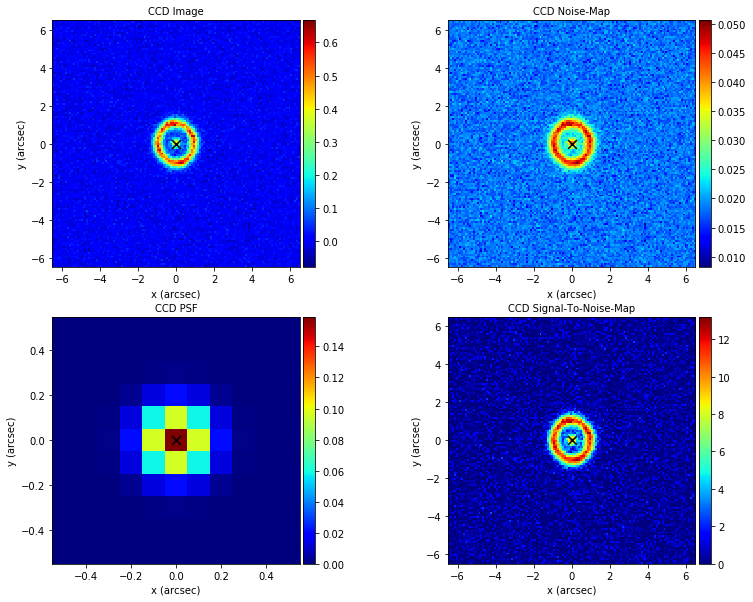

In [4]:
ccd_data = simulate()
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

To make a pipeline, we call one long function which is written in its own Python module, '_tutorial_1_pipeline_lens_and_source.py_'. Before we check it out, lets get the pipeline running. To do this, we import the module and run its 'make_pipeline' function.

When we run the make_pipeline function, we specify a pipeline_path to structure the way our output is stored - this will be explained in a moment.

In [5]:
from workspace.howtolens.chapter_3_pipelines import tutorial_1_pipeline_lens_and_source

pipeline_lens_and_source = tutorial_1_pipeline_lens_and_source.make_pipeline(
    pipeline_path='howtolens/c3_t1_lens_and_source/')

To run a pipeline, we simply use its 'run' function, passing it the data we want to run the pipeline on. Simple, huh?

In [6]:
pipeline_lens_and_source.run(data=ccd_data)

/home/jammy/PyCharm/Projects/AutoLens/workspace/output/howtolens/c3_t1_lens_and_source/pipeline_light_and_source/phase_1_lens_light_only/optimizer/multinest.txt
Removed no burn in


AttributeError: 'LensProfileFit' object has no attribute 'unmasked_lens_plane_model_image'

Okay, good job, we're running out first pipeline in PyAutoLens! But what does it *actually* do? Well, to find that out, now go to the module '_tutorial_1_pipeline_lens_and_source.py_', which contains a full description of the pipeline, as well as an overview of some tools we use to write the best, most general pipelines possible. Once you're done, come back to this pipeline runner script and we'll wrap up tutorial 1.

And there we have it, a pipeline that breaks the analysis of the lens and source galaxy into 3 simple phases. This approach is signifcantly faster than fitting the lens and source simultaneously from the beginning. Instead of asking you questions at the end of this chapter's tutorials, I'm gonna give Q&A's - this'll hopefully get you thinking about how to approach pipeline writing.

1) Can this pipeline really be generalized to any lens? Surely the radii of the masks in phase 1 and 2 depend on the lens and source galaxies?

Whilst this is true, we've chosen values of masks radii above that are 'excessive' and mask out a lot more of the image than just the source (which, in terms of run-time, is desirable). Thus, provided you know the Einstein radius distribution of your lens sample, you can choose masks radii that will masks out every source in your sample adequately (and even if some of the source is still there, who cares? The fit to the lens galaxy will be okay).

Furthermore, we discussed in chapter 2, tutorial 8 the ability to input custom masks to a phase. You can also input custom masks to a pipeline, which are used by default if a mask_function is not supplied. I haven't included a howtolens tutorial on this, but if you navigate to the '_workspace/pipelines/examples/_' folder you'll find an example pipeline describingn how to do this ('_mask_and_positions.py_').

2) What if my source galaxy isn't a ring of light? Surely my Annulus masks won't match it?
    
Just use the annulus anyway! Yeah, you'll masks out lots of image pixels with no source light, but remember, at the beginning of the pipeline, *we don't care*. In phase 3, we'll use a large circular masks and do the fit properly.
